In [56]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate,cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report 
import matplotlib.pyplot as plt
import random
import seaborn as sns

In [57]:
import warnings 
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

## 1. Loading Data and Inspecting

In [58]:
#Source
#https://www.kaggle.com/joniarroba/noshowappointments
data = pd.read_csv('KaggleV2-May-2016.csv')

In [9]:
data.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


We should do some sort of geogrpahic categorical breakdown. Maybe map the nighboorhood to certain demographic details, and work off of those.

In [10]:
data.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [12]:
#Analysis

In [59]:
# map labels to 1/0

data['Labels'] = data['No-show'].map({'Yes': 1, 'No': 0})

The dataset is imbalanced (approx. 80/20 ratio of No/Yes).  Measuring classifier accuracy is probably not useful unless the accuracy is well over 80%. 

In [60]:
no = len(data[data['No-show']=='No'])
yes = len(data[data['No-show']=='Yes'])
total = len(data)

print('Number of Rows with No-Show = Yes: ', yes,'(',np.round(yes/total*100,2),'%), Number of rows with No-show = No: ', no,'(',np.round(no/total*100,2),'%)')

Number of Rows with No-Show = Yes:  22319 ( 20.19 %), Number of rows with No-show = No:  88208 ( 79.81 %)


## 2. Editing/Adding Features and Labels

**New Features Created:**

"days_to_appt" - days between scheduling date and appt date (numerical)

"day_of_appt" - day of the week of the appt (categorical)

"month_of_appt" - month of the year of the appt (categorical)

"day_of_scheduling" - day of week appt was scheduled on (categorical)

"month_of_scheduling" - month of year appt was scheduled on (categorical)

**Final Features/Labels of Interest:**

Numerical: Age, days_to_appt, Handcap

Categorical: Gender, Hipertension, Diabetes, Alcoholism, SMS_received, day_of_appt, month_of_appt, day_of_scheduling, month_of_scheduling 

Labels: No-show (Yes=1, No=0)



In [61]:
# convert date objects to datetime format (without time part)
data['ScheduledDayDT'] = pd.to_datetime(data['ScheduledDay']).dt.date
data['ScheduledDayDT'] = pd.to_datetime(data['ScheduledDayDT'])
data['AppointmentDayDT'] = pd.to_datetime(data['AppointmentDay'])

In [62]:
# create new feature - "days_to_appt" - no. of days between scheduled date and appt date
data['time_between_appts'] = data['AppointmentDayDT']-data['ScheduledDayDT']
data['days_to_appt'] = data['time_between_appts']/np.timedelta64(1,'D')

In [63]:
# create new features - day of the week and month of the year of the scheduling and appointment dates
data['day_of_appt'] = data['AppointmentDayDT'].dt.dayofweek
data['day_of_scheduling'] = data['ScheduledDayDT'].dt.dayofweek
data['month_of_appt'] = data['AppointmentDayDT'].dt.month
data['month_of_scheduling'] = data['ScheduledDayDT'].dt.month

In [64]:
#Has the same Patient been there before (e.g same PatientID appears multiple times)?
data['count_visits'] = data.groupby('PatientId')['PatientId'].transform('count')
#data.loc[data['PatientId'] == 22638656.0]

In [65]:
# map labels to 1/0
data['Labels'] = data['No-show'].map({'Yes': 1, 'No': 0})

Correlation and Heat map

In [20]:
#Correlation analysis
corr=data.corr()
corr=abs(corr)
corr["Labels"]
#corr.sort_values(ascending=False)

PatientId              0.001461
AppointmentID          0.162602
Age                    0.060319
Scholarship            0.029135
Hipertension           0.035701
Diabetes               0.015180
Alcoholism             0.000196
Handcap                0.006076
SMS_received           0.126431
Labels                 1.000000
days_to_appt           0.186231
day_of_appt            0.001165
day_of_scheduling      0.006020
month_of_appt          0.020886
month_of_scheduling    0.160862
count_visits           0.031194
Name: Labels, dtype: float64

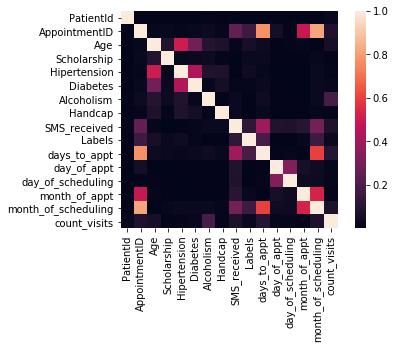

In [21]:
#Heatmap
ax = sns.heatmap(corr,  square=True)

In [66]:
# keep only desired features and labels
data_clean = data[['Gender','Age','Hipertension','Diabetes','Alcoholism','Handcap','SMS_received','Scholarship',
                  'Labels','day_of_appt','day_of_scheduling','days_to_appt','month_of_appt','month_of_scheduling','count_visits']]

In [67]:
data_clean.columns

Index(['Gender', 'Age', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap',
       'SMS_received', 'Scholarship', 'Labels', 'day_of_appt',
       'day_of_scheduling', 'days_to_appt', 'month_of_appt',
       'month_of_scheduling', 'count_visits'],
      dtype='object')

## 3. Prepare for Modelling

The cleaned data is divided into train/test sets (70/30) ratio. OneHotEncoder() is used for all categorical features (except the ones already encoded from the source) and StandardScaler() for numerical features.

In [68]:
# This function prepares the datafame, dividing into train/test, seperating features from labels, and scaling/one hot encoding
# split into train/test, stratify by Label column
train_set,test_set = train_test_split(data_clean,test_size=0.3,stratify=data_clean["Labels"])
print(len(train_set), "train +", len(test_set), "test")

# divide into features/labels
train_features = train_set.drop('Labels',axis=1)
train_labels = train_set[['Labels']]
test_features = test_set.drop('Labels',axis=1)
test_labels = test_set[['Labels']]

77368 train + 33159 test


In [26]:
data_clean.head()

,Gender,Age,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Scholarship,Labels,day_of_appt,day_of_scheduling,days_to_appt,month_of_appt,month_of_scheduling,count_visits
0,F,62,1,0,0,0,0,0,0,4,4,0.0,4,4,2
1,M,56,0,0,0,0,0,0,0,4,4,0.0,4,4,2
2,F,62,0,0,0,0,0,0,0,4,4,0.0,4,4,2
3,F,8,0,0,0,0,0,0,0,4,4,0.0,4,4,2
4,F,56,1,1,0,0,0,0,0,4,4,0.0,4,4,1


In [27]:
data_clean.describe()

,Age,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Scholarship,Labels,day_of_appt,day_of_scheduling,days_to_appt,month_of_appt,month_of_scheduling,count_visits
count,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,37.088874,0.197246,0.071865,0.030400,0.022248,0.321026,0.098266,0.201933,1.858243,1.851955,10.183702,5.210048,4.823871,3.540628
std,23.110205,0.397921,0.258265,0.171686,0.161543,0.466873,0.297675,0.401444,1.371672,1.378520,15.254996,0.473780,0.715801,6.562050
min,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.000000,4.000000,1.000000,1.000000
25%,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,5.000000,4.000000,1.000000
50%,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,4.000000,5.000000,5.000000,2.000000
75%,55.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,3.000000,3.000000,15.000000,5.000000,5.000000,4.000000
max,115.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000,5.000000,5.000000,179.000000,6.000000,12.000000,88.000000


In [69]:
# transform numerical and categorical features using StandardScaler() and OneHotEncoder()
#dont have to onehot encode already onehot encoded columns
num_attribs = ['Age','days_to_appt','Handcap',"count_visits"]
cat_attribs = ['Gender','Hipertension','Diabetes','Alcoholism','SMS_received','day_of_appt',
          'Scholarship','month_of_appt','day_of_scheduling','month_of_scheduling']

#subset to only categorical features that need to be one hot encoded. A few are alreayd encoded from the data source
cat_attribs_one_hot= ['Gender','day_of_appt','month_of_appt','Handcap',
                      'day_of_scheduling','month_of_scheduling']

pipeline_features = ColumnTransformer(
    [("num",StandardScaler(),num_attribs),
     ("cat",OneHotEncoder(categories='auto'),cat_attribs_one_hot)]
)

train_features_prepared = pipeline_features.fit_transform(train_features)
train_labels_prepared = train_labels.values

test_features_prepared = pipeline_features.transform(test_features)
test_labels_prepared = test_labels.values

In [ ]:
train_features_prepared.shape

In [ ]:
train_features.head()

In [ ]:
df_train_features_prepared=pd.DataFrame(train_features_prepared.toarray())
df_train_features_prepared.head()

## 4. Testing Some Models

A few classifiers are trained below, with 3 cross-validation folds. 

For KNN, sqrt(n_samples) was used as n_neighbors, as usually suggested in literature.


In [72]:
# This Function Runs Several Classifiers on Training Data with 3 cv-folds, Prints Out "metric" score of each Model
 
def testClassifiers(train_features,train_labels,metric=[]):
    LOG=LogisticRegression()
    DTC=DecisionTreeClassifier()
    RFC=RandomForestClassifier(n_estimators=100)
    KNN=KNeighborsClassifier()
    SGD=SGDClassifier()
    SVC_CLF = SVC(kernel="rbf") #This runs very slow!

    classifier_list = [LOG,DTC,KNN,RFC,SGD,SVC_CLF]# RFC and SVC_CLF take long.

    for c in classifier_list:
        print(type(c).__name__)
        for m in metric:
            #can use cross_validate with multiple scores insteadto make this run faster
            cv_results = cross_val_score(c,train_features_prepared,train_labels_prepared,cv=3,scoring=m)
            print('-------------------')
            print('Scoring Metric: ', m)
            print('Scores: ',cv_results)
            print('Mean Score: ',np.round(np.mean(cv_results),2))
            print('')

In [71]:
testClassifiers(train_features,train_labels, ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

LogisticRegression
-------------------
Scoring Metric:  accuracy
Scores:  [0.79542458 0.79321442 0.79517605]
Mean Score:  0.79

-------------------
Scoring Metric:  precision
Scores:  [0.30681818 0.2909699  0.3540856 ]
Mean Score:  0.32

-------------------
Scoring Metric:  recall
Scores:  [0.01036866 0.01670507 0.01747647]
Mean Score:  0.01

-------------------
Scoring Metric:  f1
Scores:  [0.02005944 0.03159615 0.03330893]
Mean Score:  0.03

-------------------
Scoring Metric:  roc_auc
Scores:  [0.66945784 0.66144923 0.66752142]
Mean Score:  0.67

DecisionTreeClassifier
-------------------
Scoring Metric:  accuracy
Scores:  [0.73660333 0.73109732 0.73309291]
Mean Score:  0.73

-------------------
Scoring Metric:  precision
Scores:  [0.34389321 0.32788209 0.33602045]
Mean Score:  0.34

-------------------
Scoring Metric:  recall
Scores:  [0.32469278 0.31125192 0.32974842]
Mean Score:  0.32

-------------------
Scoring Metric:  f1
Scores:  [0.33777429 0.3194499  0.33388559]
Mean Score:

Random Forests seem to give best models. But Precision & Recall are still very low, so this model needs to be tuned. Or more feature engineering.

Next steps
1)need a bit more data analysis at the begining to understand the dataset (graphs etc..) 2. some curves like the Precision-Recall curve to understand models.